In [1]:
import urllib.request
with urllib.request.urlopen("http://deeplearning.net/tutorial/code/utils.py") as url:
    response = url.read()
target = open('utils.py', 'w')
target.write(response.decode('utf-8'))
target.close()

In [8]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
#!pip install pillow
from PIL import Image
from utils import tile_raster_images
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)
trX,trY,teX,teY = mnist.train.images,mnist.train.labels,mnist.test.images,mnist.test.labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [5]:
trX[1].shape

(784,)

In [6]:
#images have 784 pixels. so the vissible layer must have 784 input nodes

vb = tf.placeholder("float",[784])
hb = tf.placeholder("float",[50])

#e will be the tensor of 784x50 (784 visible neurons, and 50 hidden)
w = tf.placeholder("float",[784,50])

#visible layer
v0_state = tf.placeholder("float",[None,784])
#hidden layer
h0_prob = tf.nn.sigmoid(tf.matmul(v0_state,w) + hb) # probabilities of the units
h0_state = tf.nn.relu(tf.sign(h0_prob - tf.random_uniform(tf.shape(h0_prob)))) #sample of given x

#reconstruction
v1_prob = tf.nn.sigmoid(tf.matmul(h0_state,tf.transpose(w)+vb))
v1_state = tf.nn.relu(tf.sign(v1_prob-tf.random_uniform(tf.shape(v1_prob)))) #samplev given h

#compute error as a sum of the squared difference between step 1 and step n
#it sows the difference between the data and its reconstruction
err = tf.reduce_mean(tf.square(v0_state - v1_state))


In [9]:
#train the model
h1_prob = tf.nn.sigmoid(tf.matmul(v1_state,w)+hb)
h1_state = tf.nn.relu(tf.sign(h1_prob - tf.random_uniform(tf.shape(h1_prob)))) 

alpha = 0.01
w_delta = tf.matmul(tf.transpose(v0_state),h0_prob)-tf.matmul(tf.transpose(v1_state),h1_prob)
update_w = w + alpha *w_delta
update_vb= vb + alpha*tf.reduce_mean(v0_state - v1_state,0)
update_hb= hb + alpha*tf.reduce_mean(h0_state - h1_state,0)

#start a session and initialize the variables
cur_w = np.zeros([784,50],np.float32)
cur_vb = np.zeros([784],np.float32)
cur_hb = np.zeros([50],np.float32)
prv_w = np.zeros([784,50],np.float32)
prv_vb = np.zeros([784],np.float32)
prv_hb = np.zeros([50],np.float32)
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [10]:
#check error of run
sess.run(err,feed_dict={v0_state:trX,w:prv_w,vb:prv_vb,hb:prv_hb})

0.48139355

Epoch: 0 reconstruction error: 0.078931
Epoch: 1 reconstruction error: 0.074838
Epoch: 2 reconstruction error: 0.073407
Epoch: 3 reconstruction error: 0.073694
Epoch: 4 reconstruction error: 0.072906


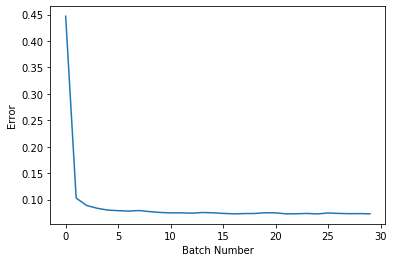

In [11]:
#parameters
epochs=5
batchsize=100
weights=[]
errors=[]

for epoch in range(epochs):
    for start,end in zip(range(0,len(trX),batchsize),range(batchsize,len(trX),batchsize)):
        batch = trX[start:end]
        cur_w=sess.run(update_w,feed_dict={v0_state:batch,w:prv_w,vb:prv_vb,hb:prv_hb})
        cur_vb=sess.run(update_vb,feed_dict={v0_state:batch,w:prv_w,vb:prv_vb,hb:prv_hb})
        cur_hb=sess.run(update_hb,feed_dict={v0_state:batch,w:prv_w,vb:prv_vb,hb:prv_hb})
        prv_w=cur_w
        prv_vb=cur_vb
        prv_hb=cur_hb
        if start %10000==0:
            errors.append(sess.run(err,feed_dict={v0_state:trX,w:prv_w,vb:prv_vb,hb:prv_hb}))
            weights.append(cur_w)
    print('Epoch: %d' % epoch,'reconstruction error: %f'%errors[-1])
plt.plot(errors)
plt.xlabel("Batch Number")
plt.ylabel("Error")
plt.show()

In [12]:
#the final weights after training
uw=weights[-1].T
print(uw)

[[-0.65075225 -0.54617316 -0.5987015  ... -0.560724   -0.5524129
  -0.58704245]
 [-1.4094619  -1.3617268  -1.3431467  ... -1.365895   -1.3612192
  -1.4062992 ]
 [-0.4402075  -0.33203402 -0.39941588 ... -0.41021386 -0.41473323
  -0.45538804]
 ...
 [-0.340425   -0.30044922 -0.3184665  ... -0.32128537 -0.29826626
  -0.30729496]
 [-0.34273437 -0.41468924 -0.39257923 ... -0.39665344 -0.41863695
  -0.46563292]
 [-0.51588786 -0.4555048  -0.48991016 ... -0.50488067 -0.46963552
  -0.53994805]]


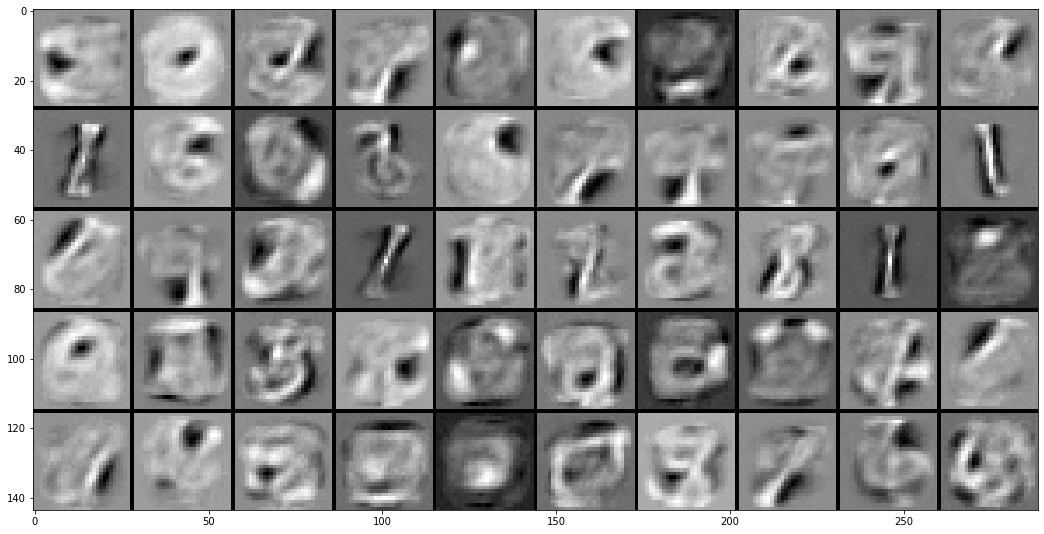

In [21]:
from utils import tile_raster_images
tile_raster_images(cur_w.T, img_shape=(28, 28), tile_shape=(5, 10), tile_spacing=(1, 1))
image = Image.fromarray(tile_raster_images(cur_w.T,img_shape=(28,28),tile_shape=(5,10),tile_spacing=(1,1)))

#plot the image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot=plt.imshow(image)
imgplot.set_cmap('gray')

'wget' is not recognized as an internal or external command,
operable program or batch file.


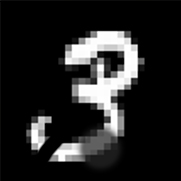

In [23]:
#plot the image
!wget -O destructed3.jpg  https://ibm.box.com/shared/static/vvm1b63uvuxq88vbw9znpwu5ol380mco.jpg
img = Image.open('destructed3.jpg')
img


In [27]:
#pass the image through the net
sample_case = np.array(img.convert('I').resize((28,28))).ravel().reshape((1,-1))/225.0

hh0_p = tf.nn.sigmoid(tf.matmul(v0_state,w)+ hb)
hh0_s = tf.round(hh0_p)
hh0_p_val,hh0_s_val = sess.run((hh0_p,hh0_s),feed_dict={v0_state:sample_case, w:prv_w, hb:prv_hb})
print("Probablility nodes in hidden layer:",hh0_p_val)
print("activated nodes in hidden layer:",hh0_s_val)

#reconstruct
vv1_p = tf.nn.sigmoid(tf.matmul(hh0_s_val,tf.transpose(w))+vb)
rec_prob = sess.run(vv1_p,feed_dict={hh0_s:hh0_s_val,w:prv_w,vb:prv_vb})



Probablility nodes in hidden layer: [[1.0000000e+00 0.0000000e+00 8.9406967e-08 0.0000000e+00 2.6822090e-07
  0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00
  9.9921632e-01 0.0000000e+00 9.9987054e-01 0.0000000e+00 0.0000000e+00
  0.0000000e+00 2.4235129e-02 2.1186471e-04 0.0000000e+00 1.0000000e+00
  3.7847340e-02 0.0000000e+00 9.9999636e-01 3.9273500e-04 1.0000000e+00
  9.9975204e-01 0.0000000e+00 1.5735626e-05 0.0000000e+00 0.0000000e+00
  9.9997532e-01 0.0000000e+00 1.4242563e-01 9.7791493e-01 1.0000000e+00
  7.9572201e-06 9.9812746e-01 0.0000000e+00 0.0000000e+00 9.9750417e-01]]
activated nodes in hidden layer: [[1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0.
  0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0.
  0. 1.]]


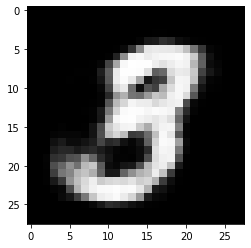

In [29]:
#display the image
img = Image.fromarray(tile_raster_images(rec_prob,img_shape=(28,28),tile_shape=(1,1),tile_spacing=(1,1)))
plt.rcParams['figure.figsize']=(4.0,4.0)
imgplot = plt.imshow(img)
imgplot.set_cmap('gray')